# **Introduction**
*Classification of chest X-ray images to detect pneumonia.*

The dataset used in this analysis contains a large number of chest X-ray images categorized as either 'NORMAL' or 'PNEUMONIA'.

Due to the limited size of the dataset and the need to improve the model's ability to generalize to unseen data, data augmentation techniques were employed. These techniques help to artificially increase the diversity of the training set by applying transformations such as rotations, zooms, and flips to the existing images.

The Project contain three different model architectures:

1.  **Sequential Model:** An initial sequential CNN model was developed. However, this model exhibited bias in its predictions, likely due to imbalances within the dataset.

2.  **Transfer Learning with DenseNet121:** Transfer learning was then applied using the DenseNet121 pre-trained model. While transfer learning generally improves performance, this specific model also did not achieve satisfactory results, possibly still influenced by biases in the data.

3.  **Transfer Learning with VGG16:** Finally, transfer learning with the VGG16 pre-trained model was implemented. This approach yielded the most promising results, demonstrating improved accuracy and a better balance in predictions across the two classes.

The subsequent sections of this notebook detail the data loading, preprocessing, model building, training, evaluation, and visualization steps involved in this pneumonia classification task.

# **Import Libraries**

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

**List Directories**

In [9]:
# List the folders present in chest_xray
os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray")

['chest_xray', '__MACOSX', 'val', 'test', 'train']

**Count Training Pneumonia Images**

In [10]:
# Count the number of pneumonia images in the training dataset.
len(os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"))

3875

**Define Data Directories**

In [11]:
# Define directories for train, test, and validation sets.
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"

**Summarize Dataset Statistics**

In [12]:
# Count and print the number of pneumonia and normal images in each dataset.
print("Train set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(train_dir, 'NORMAL')))}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


**Visualize Sample Pneumonia Images**

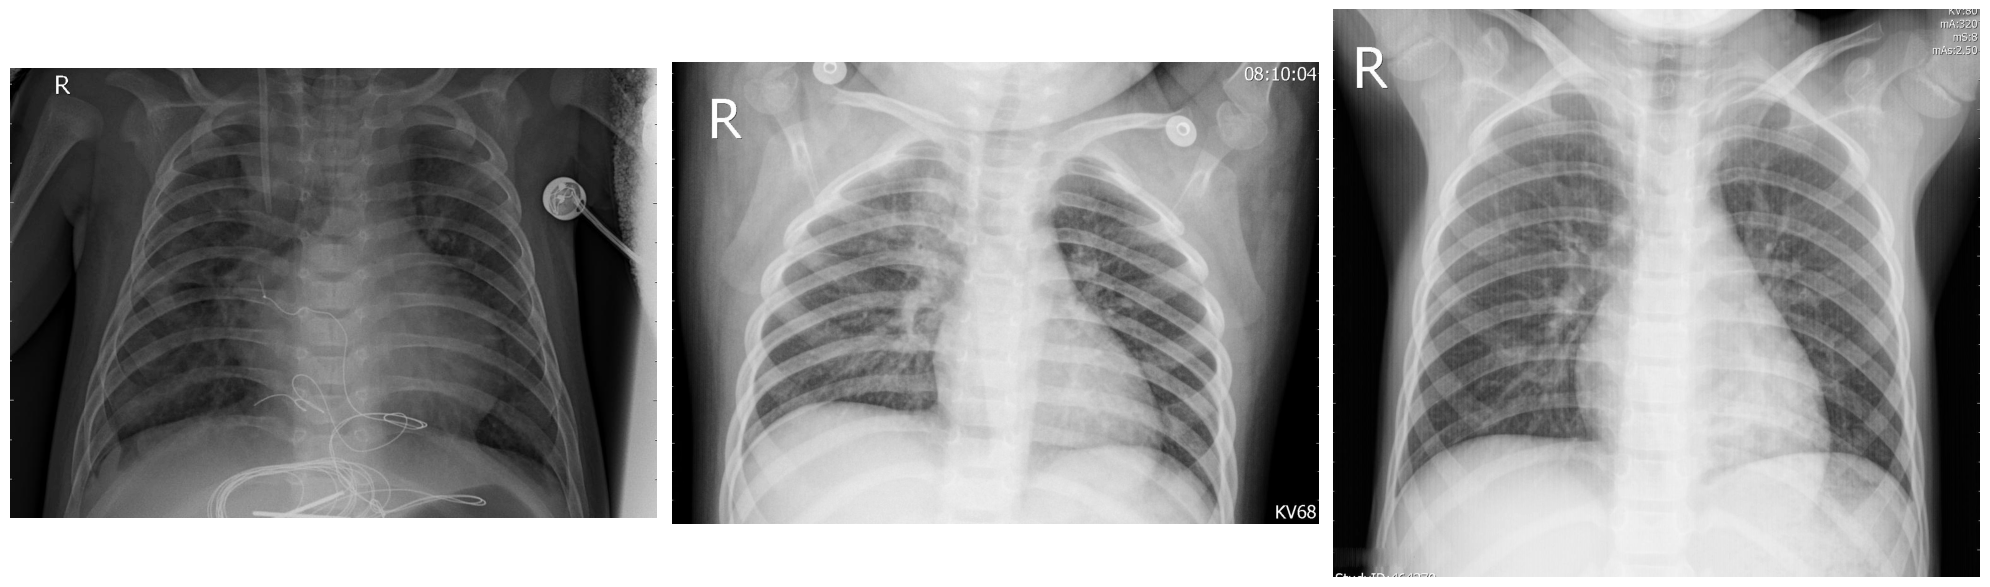

In [13]:
#visualizes 9 images from the pneumonia class in the training set.
pneumonia = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

**Visualize Sample Normal Images**

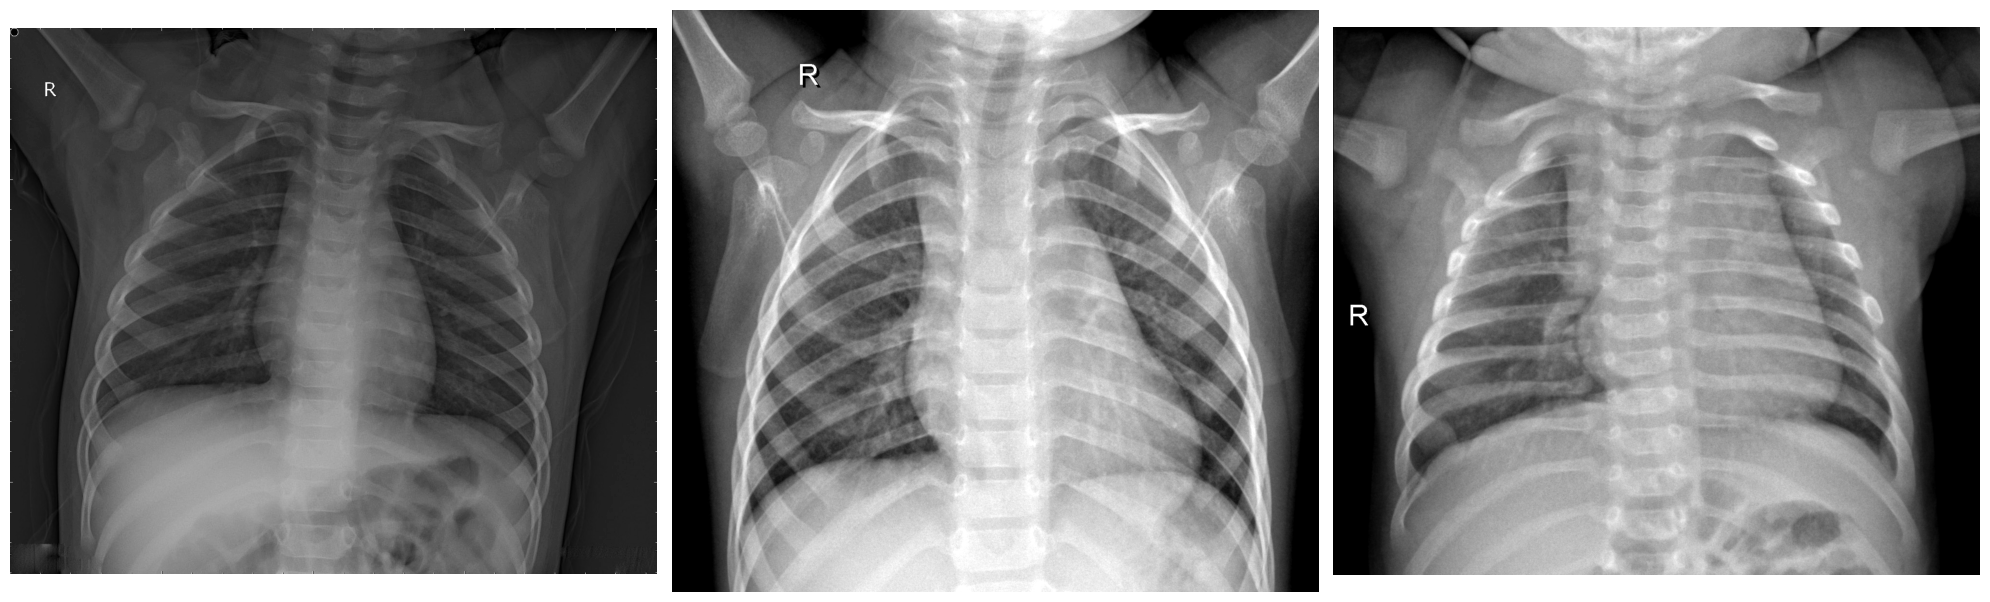

In [8]:
#Visualize 9 images from the normal class in train set.
normal = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()

**Data Augmentation Configuration**

In [14]:
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    # centers the data around zero
    samplewise_center=True,
    # standardizes the scale across all images
    samplewise_std_normalization=True
)

**Create Data Generators**

In [15]:
# Divides the images into batches , and applies the augmentations and normalization.
train = image_generator.flow_from_directory(train_dir,
                                            batch_size=8,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir,
                                                batch_size=1,
                                                shuffle=False,
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir,
                                            batch_size=1,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Check Class Imblance**

In [16]:
# Class weights
# Will actually the class imblance.
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


# **Define Sequential Model Architecture**

In [12]:
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint  # Import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import MaxPooling2D

weight_for_0 = num_normal / (num_normal + num_pneumonia)
weight_for_1 = num_pneumonia / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")


model = Sequential()

# Initial Convolutional Block
model.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(0.001)))  # L2 regularization
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))  # Increased dropout

# Fourth Convolutional Block
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                 kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Flatten the feature maps
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # Increased units, L2
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Increased dropout

model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Optimizer with a lower learning rate and decay
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

#Compile Sequential Model
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.summary()

# Define the ModelCheckpoint callback
checkpoint_filepath = 'best_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

Weight for class 0: 0.26
Weight for class 1: 0.74


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-08 05:56:43.050429: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       7,930,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 8,321,729 (31.74 MB)

 Trainable params: 8,320,257 (31.74 MB)

 Non-trainable params: 1,472 (5.75 KB)

**Train Sequential Model**

In [ ]:
r = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,  # Use the calculated class weights here
    steps_per_epoch=100,
    validation_steps=25,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.7083 - loss: 1.3040
Epoch 1: val_loss improved from inf to 12.10048, saving model to best_model.keras


C:\Users\Abdullah Randhawa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 898ms/step - accuracy: 0.7088 - loss: 1.3034 - val_accuracy: 0.5000 - val_loss: 12.1005
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.8324 - loss: 0.9982
Epoch 2: val_loss did not improve from 12.10048
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 816ms/step - accuracy: 0.8325 - loss: 0.9977 - val_accuracy: 0.5000 - val_loss: 30.7742
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.8657 - loss: 0.8241
Epoch 3: val_loss did not improve from 12.10048
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 798ms/step - accuracy: 0.8655 - loss: 0.8239 - val_accuracy: 0.5000 - val_loss: 46.8813
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 851ms/step - accuracy: 0.8443 - loss: 0.7373
Epoch 4: val_loss improved from 12.10048 to 1.85122, saving model to best_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 88s 880ms/step - accuracy: 0.8444 - loss: 0.7369 - val_accuracy: 0.6875 - val_loss: 1.8512
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 877ms/step - accuracy: 0.85

**Evaluate Model Performance**

In [15]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.2583 - loss: 1.5707
Test Accuracy: 62.50%


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


652/652 ━━━━━━━━━━━━━━━━━━━━ 163s 250ms/step - accuracy: 0.7406 - loss: 1.4616
Train Accuracy: 74.29%


**Generate Confusion Matrix and Classification Report**

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step
[[  0 234]
 [  0 390]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0           1  accuracy   macro avg  weighted avg
precision    0.0    0.625000     0.625    0.312500      0.390625
recall       0.0    1.000000     0.625    0.500000      0.625000
f1-score     0.0    0.769231     0.625    0.384615      0.480769
support    234.0  390.000000     0.625  624.000000    624.000000

**Visualize Evaluations**

# **Visualize True vs. False Predictions of Trained Sequential Model**

Found 624 images belonging to 2 classes.

Predictions for 8 Random Images:


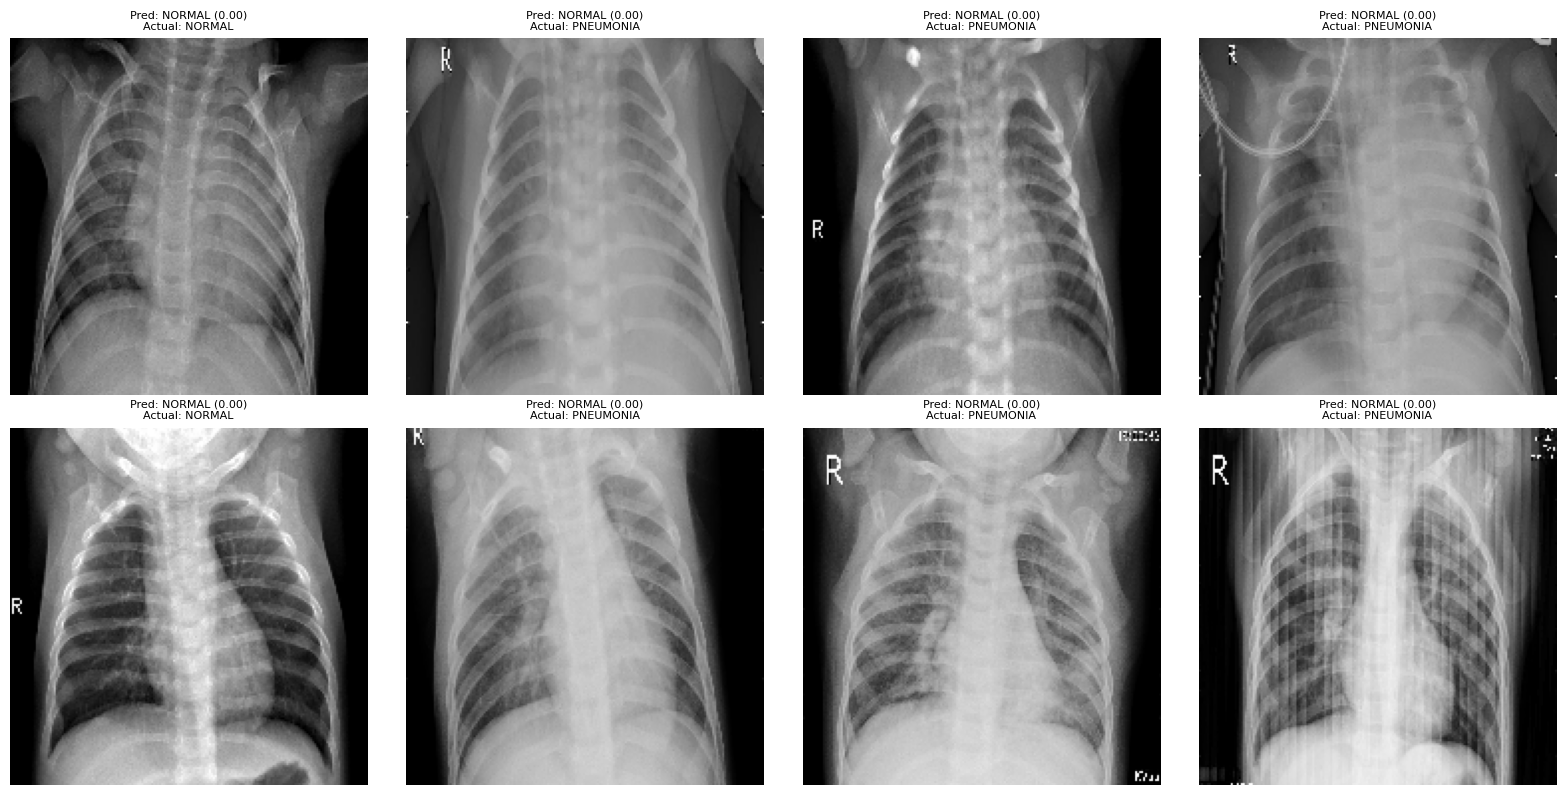

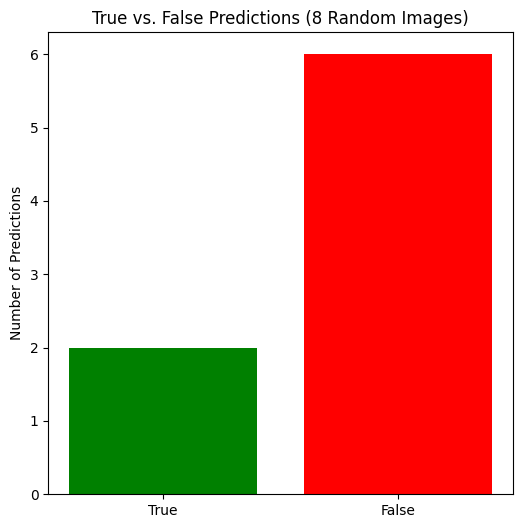

In [20]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
import matplotlib.pyplot as plt

test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)
model = keras.models.load_model("/kaggle/input/best_model/keras/default/1/best_model.keras")
filenames = test_generator.filenames
class_labels = {v: k for k, v in test_generator.class_indices.items()}
num_images = len(filenames)
random_indices = random.sample(range(num_images), min(8, num_images))  # Changed to 8
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Changed to 2x4 grid
print("\nPredictions for 8 Random Images:")

predictions = []  # List to store prediction results (True/False)
for i, ax in zip(random_indices, axes.flatten()):
    img_path = os.path.join(test_dir, filenames[i])
    img = keras.preprocessing.image.load_img(img_path, target_size=(180, 180))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array, verbose=0)[0][0]
    predicted_label = "PNEUMONIA" if pred > 0.5 else "NORMAL"
    original_class_index = test_generator.classes[i]
    original_label = class_labels[original_class_index]
    ax.imshow(img)
    ax.set_title(f"Pred: {predicted_label} ({pred:.2f})\nActual: {original_label}", fontsize=8)
    ax.axis('off')

    # Store prediction result
    predictions.append(predicted_label == original_label)

plt.tight_layout()
plt.show()

# --- Visualization of True vs. False Predictions ---
true_count = sum(predictions)
false_count = len(predictions) - true_count

plt.figure(figsize=(6, 6))
plt.bar(['True', 'False'], [true_count, false_count], color=['green', 'red'])
plt.ylabel('Number of Predictions')
plt.title('True vs. False Predictions (8 Random Images)')
plt.show()

# **Transfer learning**

# **DenseNet121 model (without its original classification layer):**

**Import libraries and Initialize DenseNet121 as base model**

In [2]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

base_model = DenseNet121(input_shape=(180, 180, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

2025-06-08 07:59:21.919141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749369562.257668      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749369562.341714      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 07:59:39.595349: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "densenet121"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 186, 186, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 90, 90, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 90, 90, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 90, 90, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 92, 92, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 45, 45, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 45, 45, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 45, 45, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 45, 45, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 45, 45, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 45, 45, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 45, 45, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 45, 45, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

**Model's no of Layers**

In [3]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

The model has 428 layers


**Define Model Architecture**

In [4]:
#model = Sequential()
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


**Diclare Callback to save best model**

In [5]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'best_chest_xray_model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)



**Compile the SFT model**

In [6]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

**Train DenseNet121 model with new data**

In [ ]:
r = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8094 - loss: 0.2088
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to best_chest_xray_model.keras


C:\Users\Abdullah Randhawa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.8097 - loss: 0.2083 - val_accuracy: 0.5625 - val_loss: 2.7221
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8462 - loss: 0.1235
Epoch 2: val_accuracy improved from 0.56250 to 0.68750, saving model to best_chest_xray_model.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - accuracy: 0.8462 - loss: 0.1236 - val_accuracy: 0.6875 - val_loss: 1.4612
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9015 - loss: 0.0905
Epoch 3: val_accuracy did not improve from 0.68750
100/100 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.9013 - loss: 0.0907 - val_accuracy: 0.5000 - val_loss: 3.0080
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9011 - loss: 0.0878
Epoch 4: val_accuracy did not improve from 0.68750
100/100 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.9012 - loss: 0.0877 - val_accuracy: 0.6875 - val_loss: 0.5658
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9194 -

**Evaluate Model Performance**

In [17]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 75s 98ms/step - accuracy: 0.2461 - loss: 1.2584
Test Accuracy: 29.49%
652/652 ━━━━━━━━━━━━━━━━━━━━ 325s 497ms/step - accuracy: 0.3225 - loss: 1.1437
Train Accuracy: 32.63%


**Generate Confusion Matrix and Classification Report**

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
predicted_vals = model.predict(test, steps=len(test))

print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

624/624 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step
[[149  85]
 [ 19 371]]


0           1  accuracy   macro avg  weighted avg
precision    0.886905    0.813596  0.833333    0.850251      0.841087
recall       0.636752    0.951282  0.833333    0.794017      0.833333
f1-score     0.741294    0.877069  0.833333    0.809181      0.826153
support    234.000000  390.000000  0.833333  624.000000    624.000000

**Visualize Evolution of Supervised Fine Tune DenseNet121 Model**

# **Visualize True vs. False Predictions of SFT DenseNet121 Model**

Found 624 images belonging to 2 classes.

Predictions for 8 Random Images:


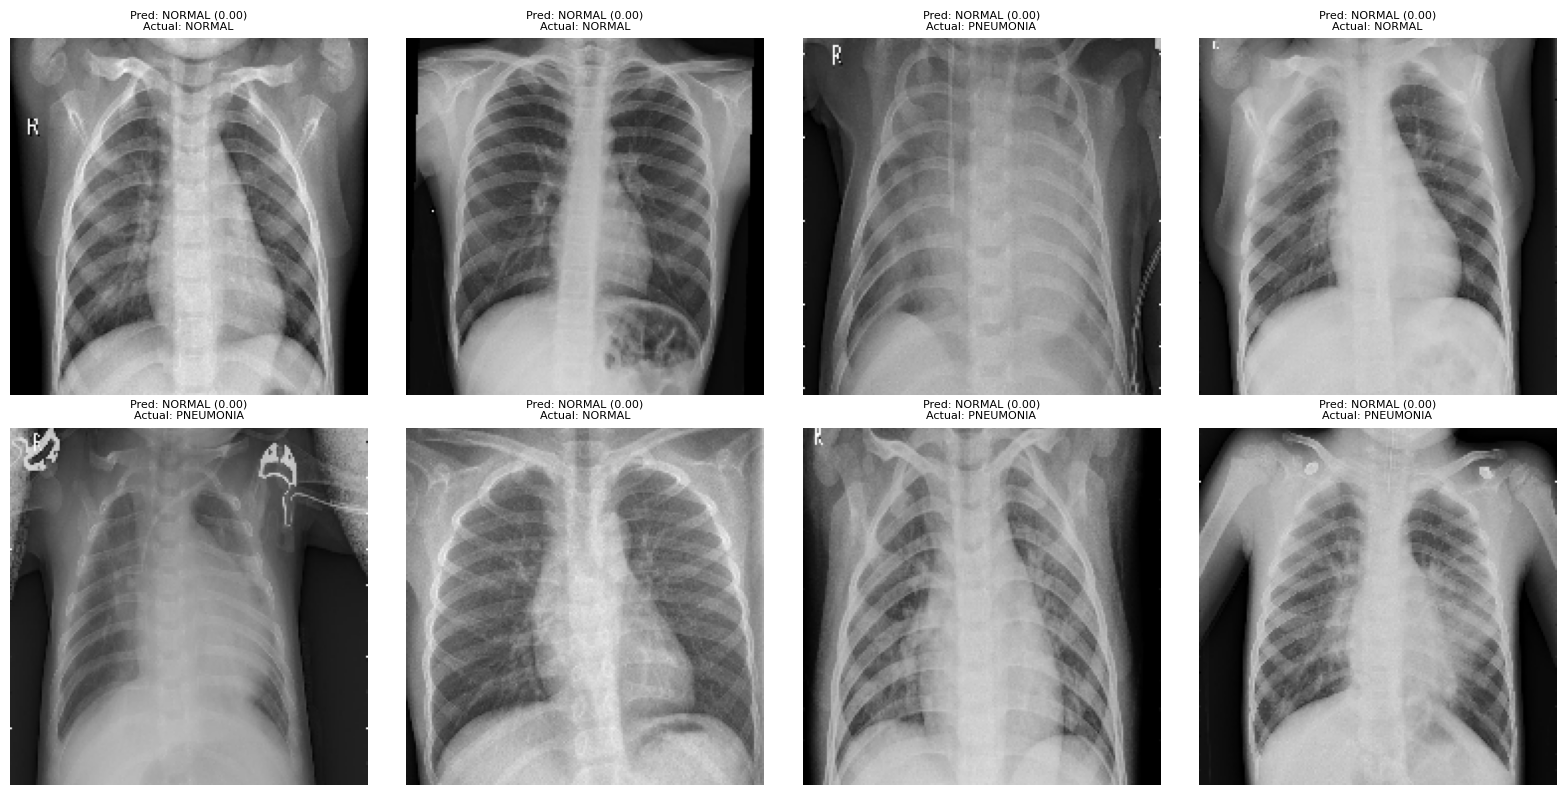

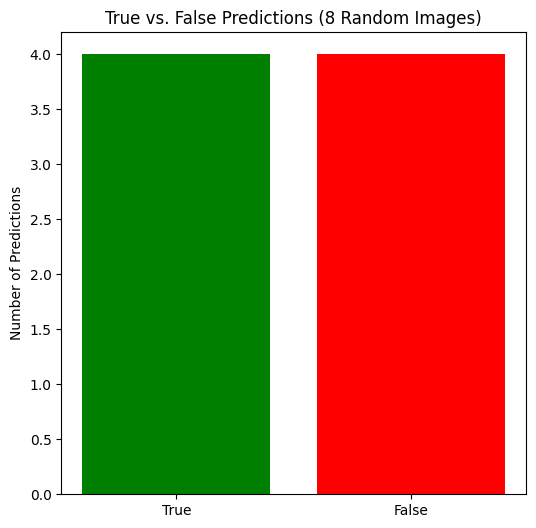

In [24]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
import matplotlib.pyplot as plt

test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)
model = keras.models.load_model("/kaggle/input/best_densenet121_model/keras/default/1/best_chest_xray_model.keras")
filenames = test_generator.filenames
class_labels = {v: k for k, v in test_generator.class_indices.items()}
num_images = len(filenames)
random_indices = random.sample(range(num_images), min(8, num_images))  # Changed to 8
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Changed to 2x4 grid
print("\nPredictions for 8 Random Images:")

predictions = []  # List to store prediction results (True/False)
for i, ax in zip(random_indices, axes.flatten()):
    img_path = os.path.join(test_dir, filenames[i])
    img = keras.preprocessing.image.load_img(img_path, target_size=(180, 180))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array, verbose=0)[0][0]
    predicted_label = "PNEUMONIA" if pred > 0.5 else "NORMAL"
    original_class_index = test_generator.classes[i]
    original_label = class_labels[original_class_index]
    ax.imshow(img)
    ax.set_title(f"Pred: {predicted_label} ({pred:.2f})\nActual: {original_label}", fontsize=8)
    ax.axis('off')

    # Store prediction result
    predictions.append(predicted_label == original_label)

plt.tight_layout()
plt.show()

# --- Visualization of True vs. False Predictions ---
true_count = sum(predictions)
false_count = len(predictions) - true_count

plt.figure(figsize=(6, 6))
plt.bar(['True', 'False'], [true_count, false_count], color=['green', 'red'])
plt.ylabel('Number of Predictions')
plt.title('True vs. False Predictions (8 Random Images)')
plt.show()

# VGG16-Model-based Transfer Learning

**Import Libraries and define Directoris**

In [26]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix  # Import metrics

# Define your data directories (adjust these paths!)
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"  # Replace with your training data directory
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"      # Replace with your validation data directory
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"    # Replace with your test data directory

**Data Augmentation Configuration + Create Data Generators**

In [27]:
# Image Data Generators with augmentation (you can adjust these)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test/val

train = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

validation = test_datagen.flow_from_directory(
    val_dir,
    target_size=(180, 180),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

test = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Check Class Weight Imblance**

In [28]:
# Class weights (IMPORTANT: Calculate from training data)
pneumonia_count = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
normal_count = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
total_count = pneumonia_count + normal_count

class_weight = {0: (1 / normal_count) * (total_count) / 2.0,
                1: (1 / pneumonia_count) * (total_count) / 2.0}

print("Class Weights:", class_weight)

Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


**Load VGG16 base Model and build Architecture**

In [29]:
# Load the VGG16 base model
vgg16_base_model = VGG16(input_shape=(180, 180, 3), include_top=False, weights='imagenet')
vgg16_base_model.trainable = False  # Freeze the base model

# Create the model
vgg16_model = Sequential([
    vgg16_base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),  # Reduced dropout slightly
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


**Compile Model and Declere Model Checkpoint callback**

In [30]:
# Compile the model
opt = Adam(learning_rate=0.00005)  # Even lower learning rate
METRICS = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
vgg16_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    'best_vgg16_model.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

**Fine Tune VGG16 Model with new tain images**

In [ ]:
# Train the model
r = vgg16_model.fit(
    train,
    epochs=10,  # You can adjust this
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,  # Or len(train) if you want to process the whole training set
    validation_steps=25,   # Or len(validation)
    callbacks=[checkpoint]
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6329 - loss: 0.6974 - precision: 0.8512 - recall: 0.5959
Epoch 1: val_accuracy improved from -inf to 0.68750, saving model to best_vgg16_model.h5


C:\Users\Abdullah Randhawa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 602s 6s/step - accuracy: 0.6333 - loss: 0.6964 - precision: 0.8517 - recall: 0.5962 - val_accuracy: 0.6875 - val_loss: 0.6148 - val_precision: 1.0000 - val_recall: 0.3750
Epoch 2/10
 63/100 ━━━━━━━━━━━━━━━━━━━━ 3:37 6s/step - accuracy: 0.7477 - loss: 0.4855 - precision: 0.9584 - recall: 0.6868
Epoch 2: val_accuracy improved from 0.68750 to 0.87500, saving model to best_vgg16_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.7517 - loss: 0.4784 - precision: 0.9579 - recall: 0.6916 - val_accuracy: 0.8750 - val_loss: 0.5628 - val_precision: 1.0000 - val_recall: 0.7500
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7798 - loss: 0.4366 - precision: 0.9666 - recall: 0.7297
Epoch 3: val_accuracy improved from 0.87500 to 0.93750, saving model to best_vgg16_model.h5


100/100 ━━━━━━━━━━━━━━━━━━━━ 590s 6s/step - accuracy: 0.7798 - loss: 0.4365 - precision: 0.9666 - recall: 0.7297 - val_accuracy: 0.9375 - val_loss: 0.4675 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 4/10
 63/100 ━━━━━━━━━━━━━━━━━━━━ 3:35 6s/step - accuracy: 0.7560 - loss: 0.4452 - precision: 0.9576 - recall: 0.7078
Epoch 4: val_accuracy did not improve from 0.93750
100/100 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.7600 - loss: 0.4394 - precision: 0.9576 - recall: 0.7121 - val_accuracy: 0.9375 - val_loss: 0.3977 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7975 - loss: 0.3905 - precision: 0.9639 - recall: 0.7496
Epoch 5: val_accuracy did not improve from 0.93750
100/100 ━━━━━━━━━━━━━━━━━━━━ 585s 6s/step - accuracy: 0.7975 - loss: 0.3905 - precision: 0.9640 - recall: 0.7497 - val_accuracy: 0.8750 - val_loss: 0.3302 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 6/10
 63/100 ━━━━━━━━━━━━━━━━━━━━ 3:39 6s/step

**Evaluate SFT VGG16 Model**

In [31]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 50s 914ms/step - accuracy: 0.2743 - loss: 7.8310
Test Accuracy: 62.50%
163/163 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - accuracy: 0.7428 - loss: 3.4816
Train Accuracy: 74.29%


**Generate Confusion Matrix and Classification Report**

In [32]:
predicted_vals = model.predict(test, steps=len(test))

print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

39/39 ━━━━━━━━━━━━━━━━━━━━ 41s 887ms/step
[[  0 234]
 [  0 390]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0           1  accuracy   macro avg  weighted avg
precision    0.0    0.625000     0.625    0.312500      0.390625
recall       0.0    1.000000     0.625    0.500000      0.625000
f1-score     0.0    0.769231     0.625    0.384615      0.480769
support    234.0  390.000000     0.625  624.000000    624.000000

**Visualization Evaluation of SFT VGG16 Model **

# **Visualize True vs. False Predictions of SFT Vgg16 Model**

Found 624 images belonging to 2 classes.

Predictions for 8 Random Images:


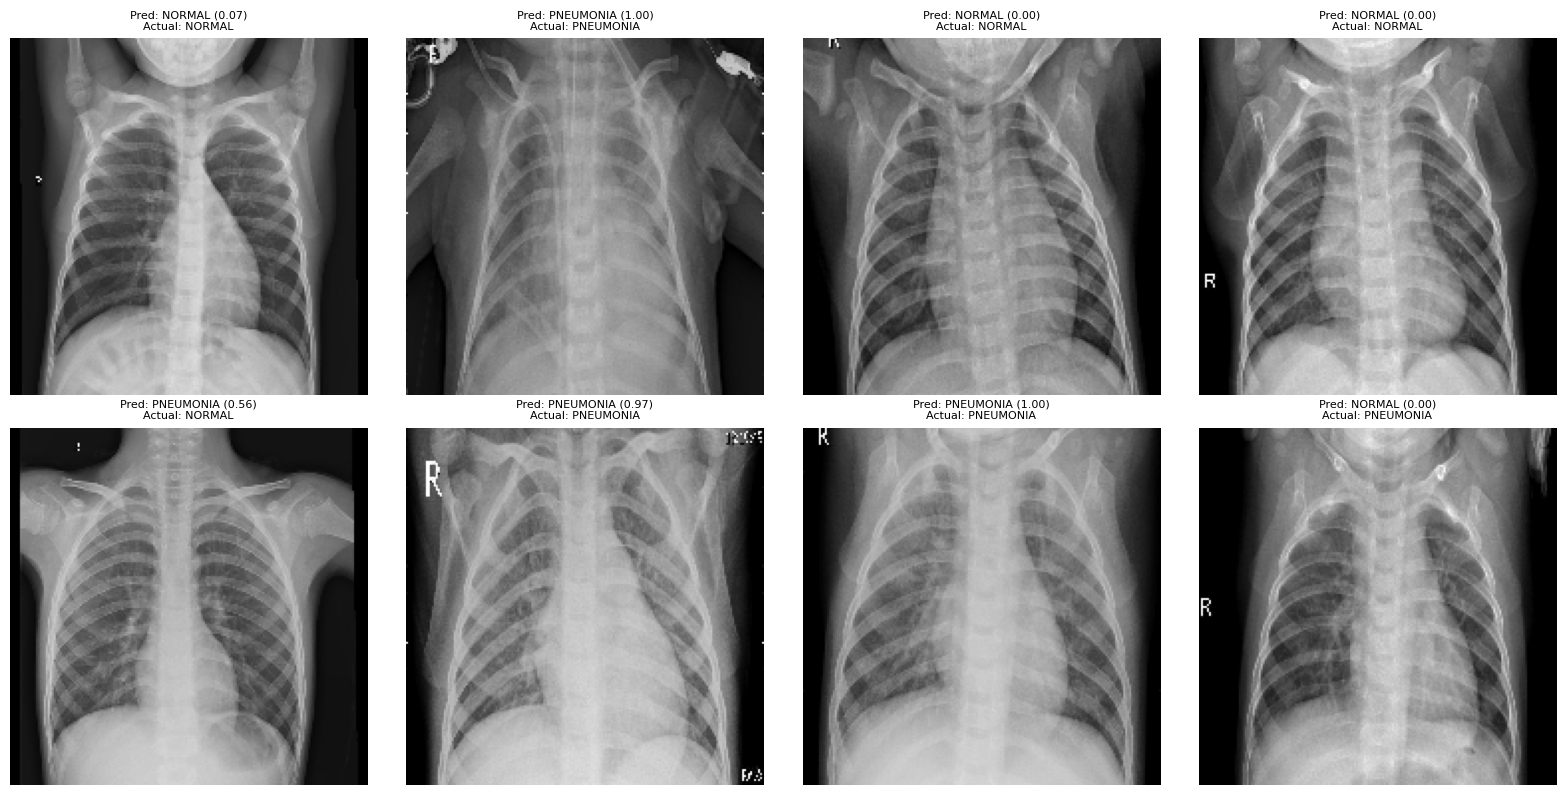

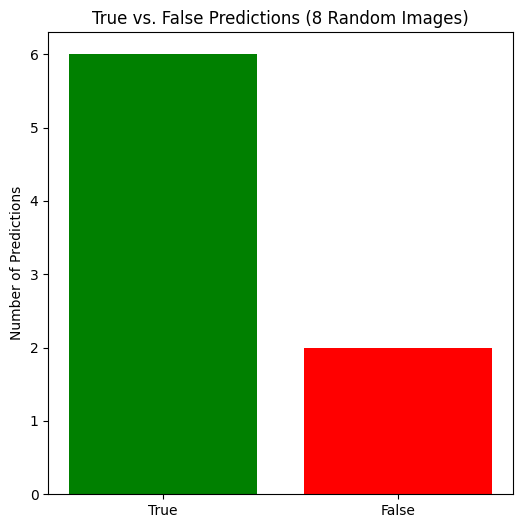

In [34]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import random
import matplotlib.pyplot as plt

test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)
model = keras.models.load_model("/kaggle/input/best_vgg16_model/keras/default/1/best_vgg16_model.h5")
filenames = test_generator.filenames
class_labels = {v: k for k, v in test_generator.class_indices.items()}
num_images = len(filenames)
random_indices = random.sample(range(num_images), min(8, num_images))  # Changed to 8
fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Changed to 2x4 grid
print("\nPredictions for 8 Random Images:")

predictions = []  # List to store prediction results (True/False)
for i, ax in zip(random_indices, axes.flatten()):
    img_path = os.path.join(test_dir, filenames[i])
    img = keras.preprocessing.image.load_img(img_path, target_size=(180, 180))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array, verbose=0)[0][0]
    predicted_label = "PNEUMONIA" if pred > 0.5 else "NORMAL"
    original_class_index = test_generator.classes[i]
    original_label = class_labels[original_class_index]
    ax.imshow(img)
    ax.set_title(f"Pred: {predicted_label} ({pred:.2f})\nActual: {original_label}", fontsize=8)
    ax.axis('off')

    # Store prediction result
    predictions.append(predicted_label == original_label)

plt.tight_layout()
plt.show()

# --- Visualization of True vs. False Predictions ---
true_count = sum(predictions)
false_count = len(predictions) - true_count

plt.figure(figsize=(6, 6))
plt.bar(['True', 'False'], [true_count, false_count], color=['green', 'red'])
plt.ylabel('Number of Predictions')
plt.title('True vs. False Predictions (8 Random Images)')
plt.show()

Pass the img path to predict: 

Enter the path to your chest X-ray image:  /kaggle/input/img-normal/IM-0036-0001.jpeg


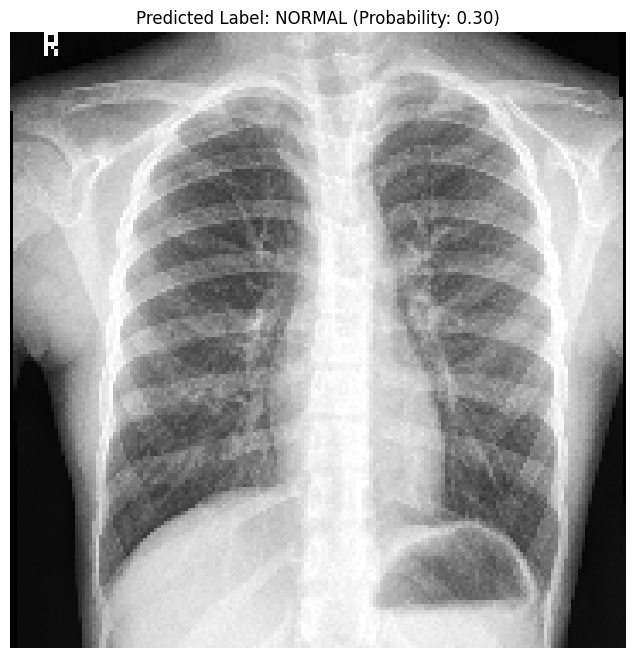

In [36]:
def predict_pneumonia(image_path, model_path="/kaggle/input/best_vgg16_model/keras/default/1/best_vgg16_model.h5"):
    model = keras.models.load_model(model_path)
    img = keras.preprocessing.image.load_img(image_path, target_size=(180, 180))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    pred = model.predict(img_array, verbose=0)[0][0]
    predicted_label = "PNEUMONIA" if pred > 0.5 else "NORMAL"
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_label} (Probability: {pred:.2f})", fontsize=12)
    plt.axis('off')
    plt.show()

if __name__ == '__main__':
    image_path = input("Enter the path to your chest X-ray image: ")
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
    else:
        predict_pneumonia(image_path)